# Project: Bitcoin Time-Series Analysis 2018-2020

## Data:
1. Main Metrics: https://coinmetrics.io/community-network-data/
2. Crypto Fear & Greed Index Over Time: https://alternative.me/crypto/
3. Tweets Likes: https://www.kaggle.com/handsomeooi/sentiment-analysis/


## Features:

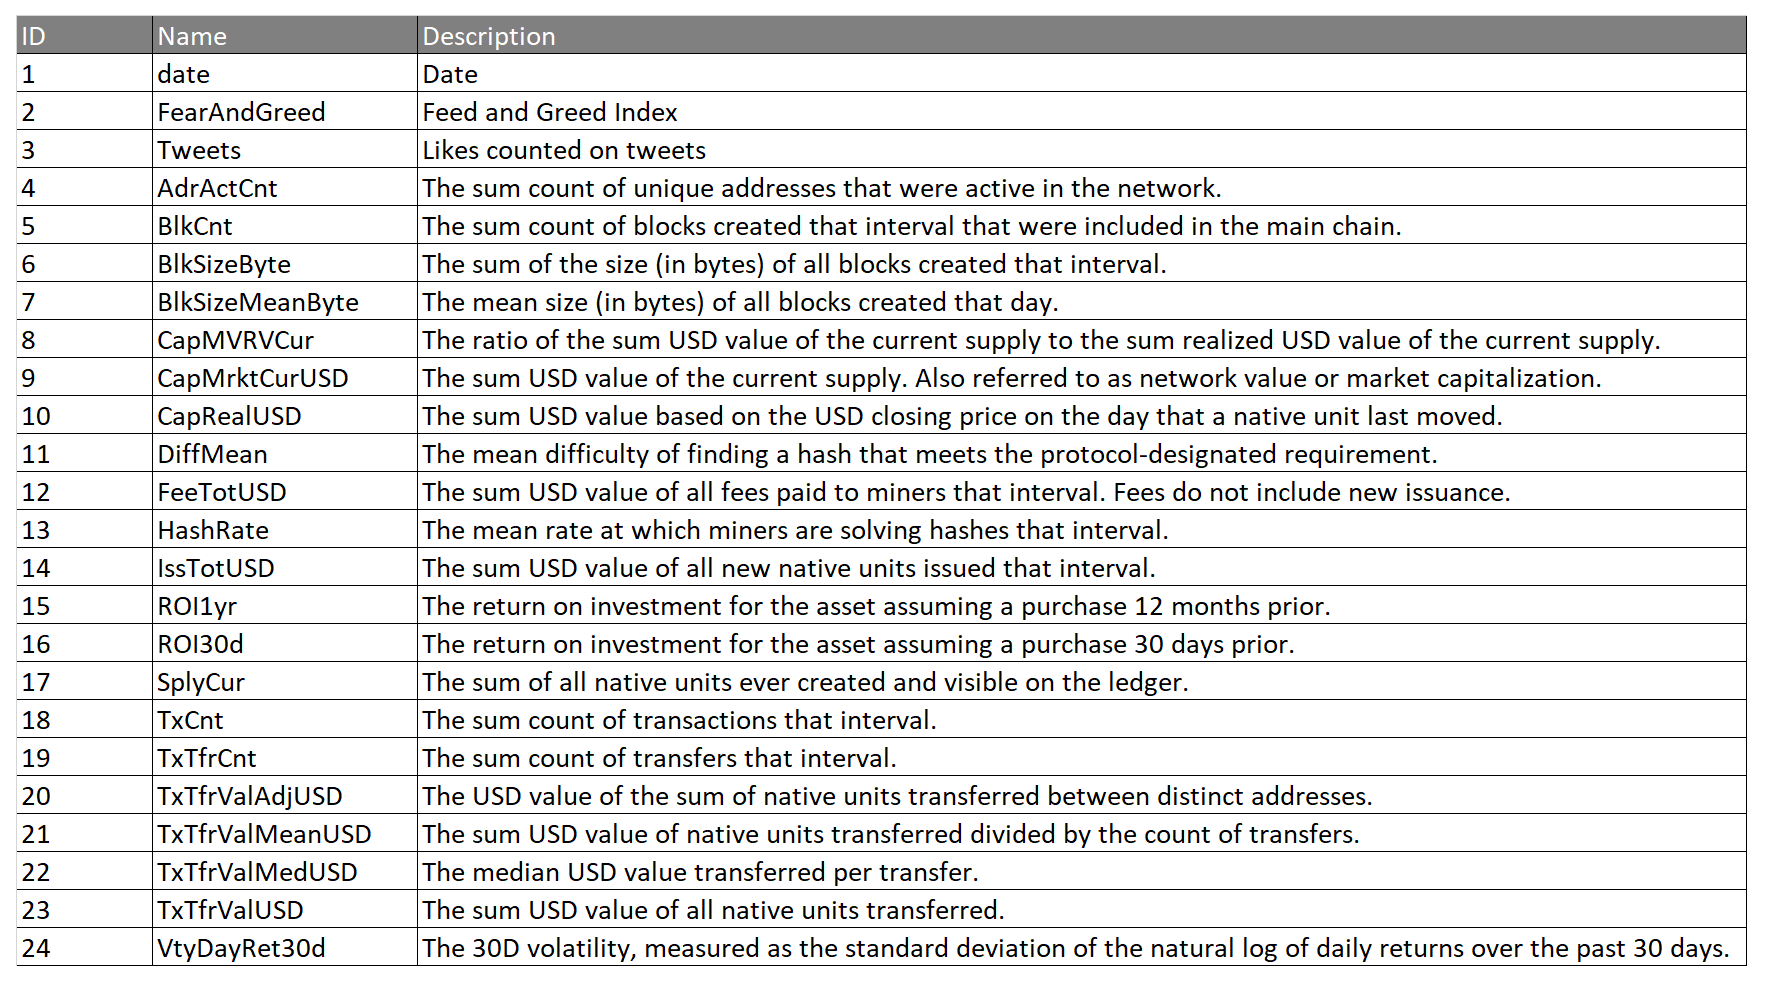

## Target:

Forecast daily Bitcoin PriceUSD for D+1

    

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

#Models
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

#Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

1. Read data 
2. Check main statistic (description, type, null values etc.)
3. Change 'Object' type to Float
4. Data set preparation for time-series analysis
5. Feature Engineering
6. Seasonal Decompose
7. Check Correlation
8. Create Transformations 
9. Build Pipeline

### 1. Read Data

In [2]:
import pandas as pd
url = 'https://raw.githubusercontent.com/TomaszDudzik/BitcoinTimeSeriesForecasting/main/Data.xlsx'
raw_df = pd.read_excel(url)

### 2. Check main statistic

In [3]:
# show first rows
raw_df.head()

,date,PriceUSD,FearAndGreed,Tweets,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,...,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,VtyDayRet30d
0,2009-01-03,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN
1,2009-01-04,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN
2,2009-01-05,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN
3,2009-01-06,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN
4,2009-01-07,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN


In [4]:
# show size of the dataset
raw_df.shape

(4454, 26)

In [5]:
# show basic info about the dataset like type and null values
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             4454 non-null   datetime64[ns]
 1   PriceUSD         3893 non-null   object        
 2   FearAndGreed     1135 non-null   float64       
 3   Tweets           3004 non-null   float64       
 4   AdrActCnt        4454 non-null   int64         
 5   BlkCnt           4454 non-null   int64         
 6   BlkSizeByte      4454 non-null   int64         
 7   BlkSizeMeanByte  4448 non-null   float64       
 8   CapMVRVCur       3893 non-null   float64       
 9   CapMrktCurUSD    3893 non-null   float64       
 10  CapRealUSD       4454 non-null   float64       
 11  DiffMean         4448 non-null   float64       
 12  FeeTotUSD        3893 non-null   float64       
 13  HashRate         4448 non-null   float64       
 14  IssTotUSD        3893 non-null   float64

In [6]:
# show null values
raw_df.isna().sum()

date                  0
PriceUSD            561
FearAndGreed       3319
Tweets             1450
AdrActCnt             0
BlkCnt                0
BlkSizeByte           0
BlkSizeMeanByte       6
CapMVRVCur          561
CapMrktCurUSD       561
CapRealUSD            0
DiffMean              6
FeeTotUSD           561
HashRate              6
IssTotUSD           561
PriceUSD.1          561
ROI1yr              926
ROI30d              591
SplyCur               0
TxCnt                 0
TxTfrCnt              0
TxTfrValAdjUSD      561
TxTfrValMeanUSD     561
TxTfrValMedUSD      561
TxTfrValUSD         561
VtyDayRet30d        591
dtype: int64

### 3. Change 'Object' type to Float

In [7]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['PriceUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD']

771    2021-05-01 00:00:00
773    2021-05-01 00:00:00
847    2021-05-03 00:00:00
849    2021-02-03 00:00:00
Name: PriceUSD, dtype: object

In [8]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['PriceUSD.1'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD.1']

771    2021-05-01 00:00:00
773    2021-05-01 00:00:00
847    2021-05-03 00:00:00
849    2021-02-03 00:00:00
Name: PriceUSD.1, dtype: object

In [9]:
# Check which rows are object type

raw_df.loc[raw_df[raw_df['TxTfrValMedUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'TxTfrValMedUSD']

585    1935-03-01 00:00:00
605    2824-02-01 00:00:00
607    2017-03-01 00:00:00
623    2021-05-03 00:00:00
640    2021-07-03 00:00:00
642    1935-03-01 00:00:00
644    1969-04-01 00:00:00
649    1955-02-01 00:00:00
650    1962-04-01 00:00:00
651    2021-05-05 00:00:00
668    1969-09-01 00:00:00
679    2021-08-13 00:00:00
688    1985-02-01 00:00:00
698    5449-02-01 00:00:00
706    2021-02-01 00:00:00
707    2028-02-01 00:00:00
721    2495-01-01 00:00:00
725    2017-01-01 00:00:00
728    8345-01-01 00:00:00
771    3335-01-01 00:00:00
778    1973-01-01 00:00:00
795    8332-04-01 00:00:00
797    1964-02-01 00:00:00
821    1936-01-01 00:00:00
Name: TxTfrValMedUSD, dtype: object

In [10]:
# Remove values from rows as object type and change the type to float

raw_df.loc[raw_df[raw_df['PriceUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD'] = None
raw_df['PriceUSD'] = raw_df.PriceUSD.astype(float)

raw_df.loc[raw_df[raw_df['PriceUSD.1'].apply(lambda x: isinstance(x, datetime.date))].index, 'PriceUSD.1'] = None
raw_df['PriceUSD.1'] = raw_df['PriceUSD.1'].astype(float)

raw_df.loc[raw_df[raw_df['TxTfrValMedUSD'].apply(lambda x: isinstance(x, datetime.date))].index, 'TxTfrValMedUSD'] = None
raw_df['TxTfrValMedUSD'] = raw_df.TxTfrValMedUSD.astype(float)

### 4. Data set preparation for time-series analysis

In [11]:
# change date column to index
raw_df = raw_df.set_index('date')
raw_df.index = pd.to_datetime(raw_df.index)

In [12]:
# only take 2 years of data where price was more stable
raw_df = raw_df.loc['2018-02-01':'2019-11-22']

In [13]:
# is data sorted
(raw_df.index == raw_df.index.sort_values()).all()

True

In [14]:
# stable frequency
print(pd.infer_freq(raw_df.index))

D


In [15]:
# are there any duplicate rows
raw_df.index.duplicated().sum()

0

In [16]:
# show null values
raw_df.isna().sum()

PriceUSD           0
FearAndGreed       3
Tweets             0
AdrActCnt          0
BlkCnt             0
BlkSizeByte        0
BlkSizeMeanByte    0
CapMVRVCur         0
CapMrktCurUSD      0
CapRealUSD         0
DiffMean           0
FeeTotUSD          0
HashRate           0
IssTotUSD          0
PriceUSD.1         0
ROI1yr             0
ROI30d             0
SplyCur            0
TxCnt              0
TxTfrCnt           0
TxTfrValAdjUSD     0
TxTfrValMeanUSD    0
TxTfrValMedUSD     0
TxTfrValUSD        0
VtyDayRet30d       0
dtype: int64

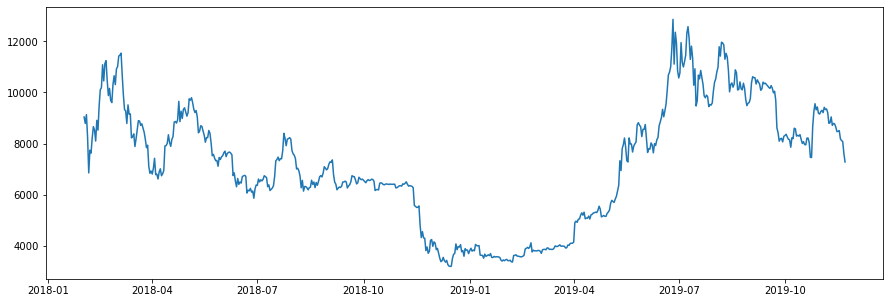

In [17]:
# Target data visualisation 
plt.figure(figsize=(15,5))
plt.plot(raw_df['PriceUSD']);

### 5. Feature Engineering

In [18]:
df_features = raw_df.copy()
df_features.head()

,PriceUSD,FearAndGreed,Tweets,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,...,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,VtyDayRet30d
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,9039.865075,30.0,57968.0,833934,160,168502440,1.053140e+06,1.696920,1.522276e+11,8.970817e+10,...,815.399164,-38.730733,1.683959e+07,252498,660268,3.821824e+09,13841.106548,221.295897,9.138840e+09,0.064782
2018-02-02,8786.077380,15.0,14991.0,853582,168,171781052,1.022506e+06,1.661519,1.479724e+11,8.905846e+10,...,771.890375,-41.466290,1.684169e+07,237739,632968,4.436626e+09,16005.150173,265.450593,1.013075e+10,0.064503
2018-02-03,9132.100322,40.0,36621.0,714800,158,157350763,9.958909e+05,1.728782,1.538180e+11,8.897476e+10,...,799.446664,-39.403331,1.684366e+07,190833,498555,2.467273e+09,12424.003745,149.685672,6.194049e+09,0.065213
2018-02-04,8250.526896,24.0,26274.0,711645,178,175907510,9.882444e+05,1.561847,1.389874e+11,8.898912e+10,...,698.088493,-51.459572,1.684589e+07,172621,454924,2.253583e+09,10987.749054,120.559999,4.998591e+09,0.061619
2018-02-05,6849.542559,11.0,73730.0,915758,185,204696944,1.106470e+06,1.308319,1.154025e+11,8.820667e+10,...,575.119203,-59.952601,1.684820e+07,221421,574790,3.416963e+09,17907.563445,164.389021,1.029309e+10,0.068027


In [19]:
def generate_date_features(df_features):
    df_features['date'] = pd.to_datetime(df_features.index)
    df_features['month'] = df_features['date'].dt.month
    df_features['month_day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek 
    df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
    return df_features

In [20]:
df_features = generate_date_features(df_features)
df_features

,PriceUSD,FearAndGreed,Tweets,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,...,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,TxTfrValUSD,VtyDayRet30d,date,month,month_day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,9039.865075,30.0,57968.0,833934,160,168502440,1.053140e+06,1.696920,1.522276e+11,8.970817e+10,...,3.821824e+09,13841.106548,221.295897,9.138840e+09,0.064782,2018-02-01,2,1,3,0
2018-02-02,8786.077380,15.0,14991.0,853582,168,171781052,1.022506e+06,1.661519,1.479724e+11,8.905846e+10,...,4.436626e+09,16005.150173,265.450593,1.013075e+10,0.064503,2018-02-02,2,2,4,0
2018-02-03,9132.100322,40.0,36621.0,714800,158,157350763,9.958909e+05,1.728782,1.538180e+11,8.897476e+10,...,2.467273e+09,12424.003745,149.685672,6.194049e+09,0.065213,2018-02-03,2,3,5,1
2018-02-04,8250.526896,24.0,26274.0,711645,178,175907510,9.882444e+05,1.561847,1.389874e+11,8.898912e+10,...,2.253583e+09,10987.749054,120.559999,4.998591e+09,0.061619,2018-02-04,2,4,6,1
2018-02-05,6849.542559,11.0,73730.0,915758,185,204696944,1.106470e+06,1.308319,1.154025e+11,8.820667e+10,...,3.416963e+09,17907.563445,164.389021,1.029309e+10,0.068027,2018-02-05,2,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-18,8183.533414,38.0,112791.0,696269,140,142883543,1.020597e+06,1.435851,1.477542e+11,1.029036e+11,...,1.809305e+09,7045.731917,83.424740,4.644821e+09,0.038884,2019-11-18,11,18,0,0
2019-11-19,8116.820673,32.0,137802.0,823018,147,166940275,1.135648e+06,1.424626,1.465647e+11,1.028794e+11,...,1.943834e+09,5641.623643,83.080692,3.937989e+09,0.038444,2019-11-19,11,19,1,0
2019-11-20,8076.554660,32.0,128950.0,702168,142,145486270,1.024551e+06,1.418362,1.458519e+11,1.028313e+11,...,1.630124e+09,5056.320664,80.765547,3.462493e+09,0.038453,2019-11-20,11,20,2,0


(7000.0, 7300.0)

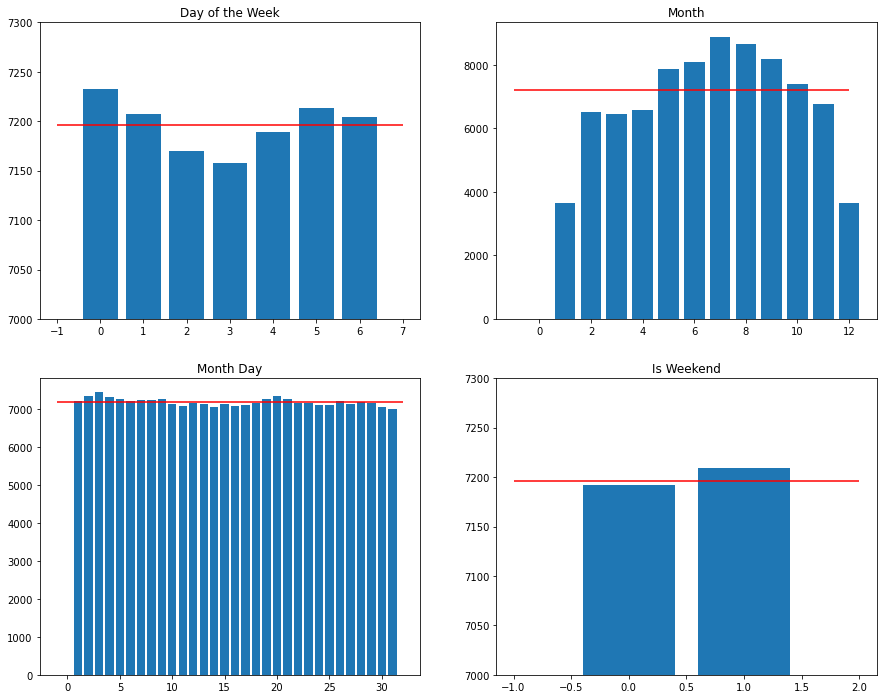

In [21]:
day_of_week = sorted(list(df_features['day_of_week'].unique()))
month = sorted(list(df_features['month'].unique()))
month_day = sorted(list(df_features['month_day'].unique()))
is_weekend = sorted(list(df_features['is_weekend'].unique()))

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mean of PriceUSD depending on the day of week (0 - Monday; ... 6 - Sunday)
axs[0, 0].set_title('Day of the Week')
axs[0, 0].bar(day_of_week,df_features.groupby('day_of_week').mean()['PriceUSD'])
axs[0, 0].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=7, color='red')
axs[0, 0].set_ylim(7000, 7300)

# Mean of PriceUSD depending on the month
axs[0, 1].set_title('Month')
axs[0, 1].bar(month,df_features.groupby('month').mean()['PriceUSD'])
axs[0, 1].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=12, color='red')

# Mean of PriceUSD depending on the day of month
axs[1, 0].set_title('Month Day')
axs[1, 0].bar(month_day,df_features.groupby('month_day').mean()['PriceUSD'])
axs[1, 0].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=32, color='red')

# Mean of PriceUSD depending if this is a weekend or workday
axs[1, 1].set_title('Is Weekend')
axs[1, 1].bar(is_weekend,df_features.groupby('is_weekend').mean()['PriceUSD'])
axs[1, 1].hlines(df_features['PriceUSD'].mean(), xmin=-1, xmax=2, color='red')
axs[1, 1].set_ylim(7000, 7300)

In [22]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        df_features = X.copy()
        
        df_features['date'] = pd.to_datetime(df_features.index)
        df_features['month'] = df_features['date'].dt.month
        df_features['day_of_week'] = df_features['date'].dt.dayofweek 
        df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
        
        
        # drop unnecessary columns
        df_features = df_features.drop('date', axis=1)
    
        return df_features

### 6. Seasonal Decompose

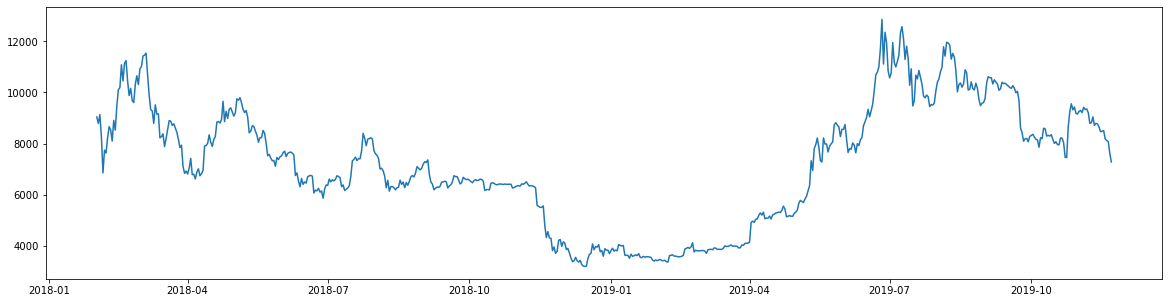

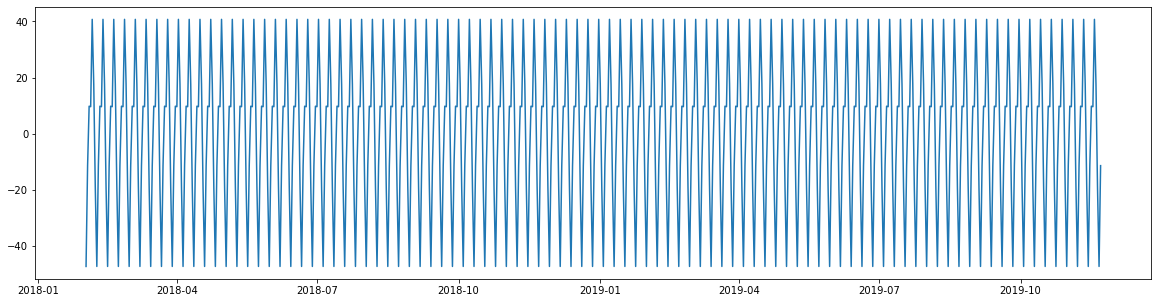

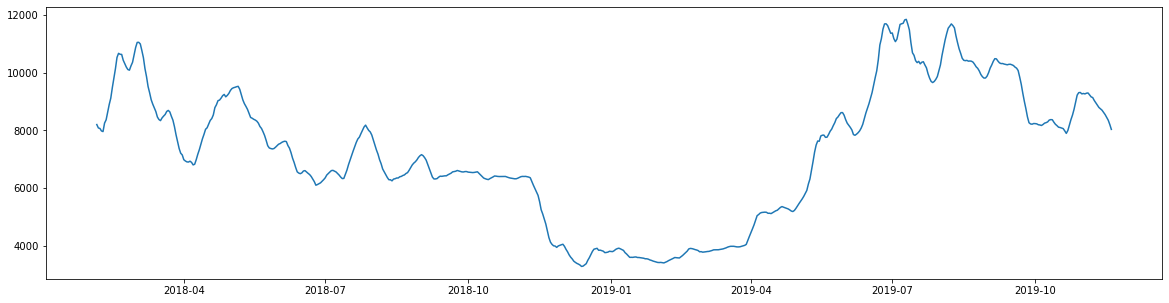

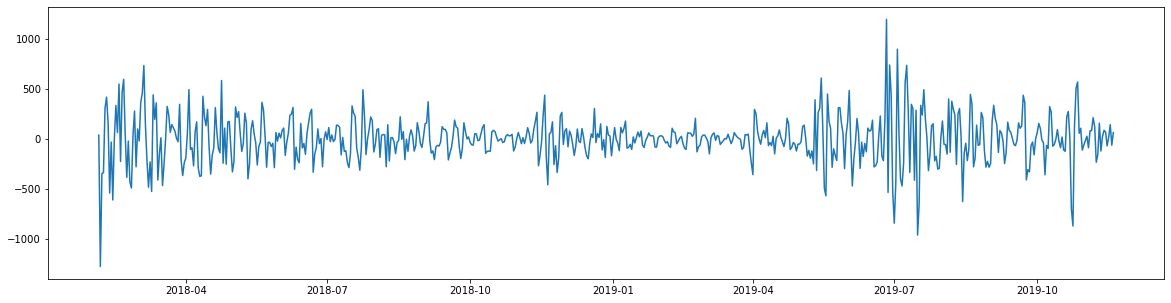

In [23]:
result = seasonal_decompose(df_features['PriceUSD'])
df_features['seasonality'] = result.seasonal
df_features['trend'] = result.trend
plt.figure(figsize=(20,5))
plt.plot(df_features['PriceUSD'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(df_features['seasonality'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(df_features['trend'])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(result.resid)
plt.show()

### 7. Check Correlation

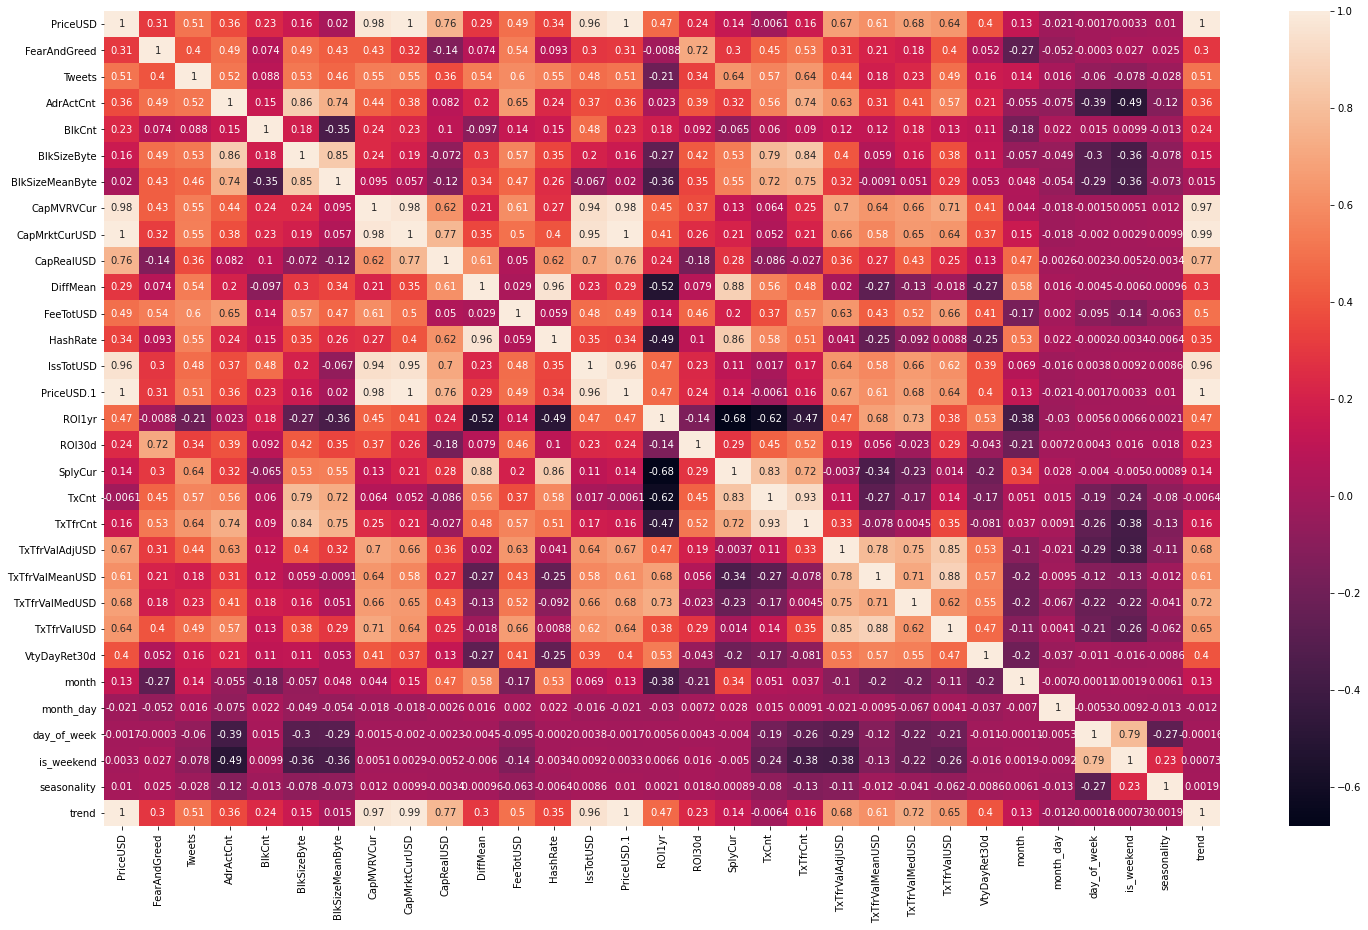

In [24]:
plt.figure(figsize=(25,15))
sns.heatmap(df_features.corr(), annot=True)

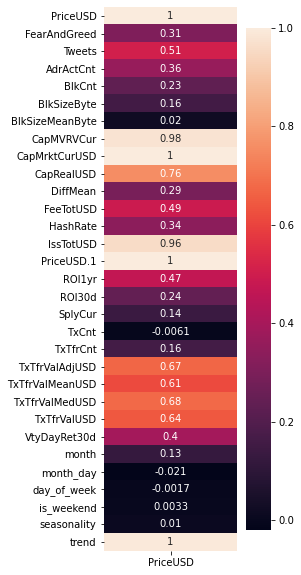

In [25]:
plt.figure(figsize=(3,10))
sns.heatmap(pd.DataFrame(df_features.corr()['PriceUSD']), annot=True)

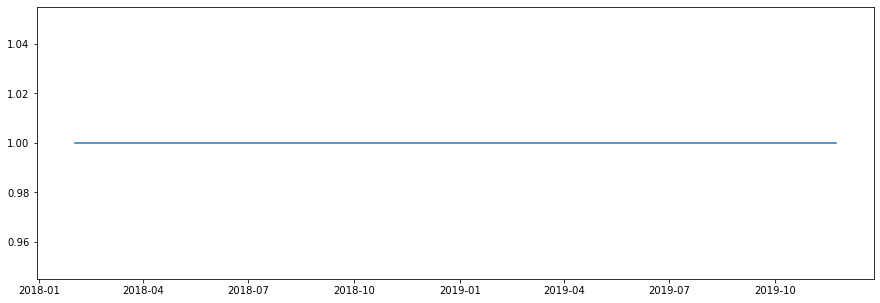

In [26]:
# PriceUSD and PriceUSD.1 are duplicated columns

plt.figure(figsize=(15,5))
plt.plot(df_features['PriceUSD']/df_features['PriceUSD.1']);

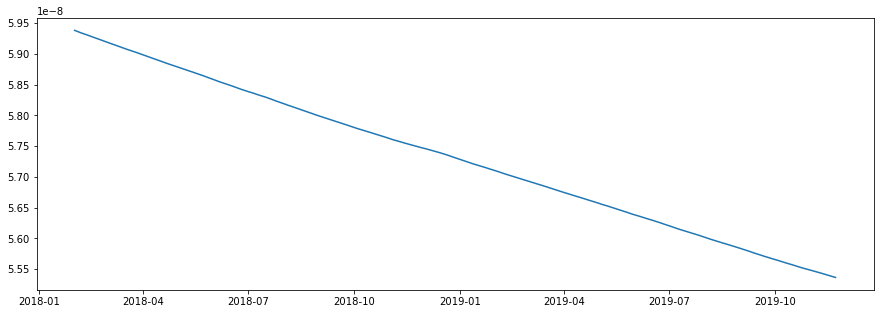

In [27]:
# PriceUSD divided by CapMrktCurUSD 

plt.figure(figsize=(15,5))
plt.plot(df_features['PriceUSD']/df_features['CapMrktCurUSD']);

In [28]:
# Correlation - columns with < 0.5 corr

correlation = df_features.corr()['PriceUSD']
not_correlated_columns = correlation[correlation < 0.5].index.tolist()
print(not_correlated_columns)

['FearAndGreed', 'AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'DiffMean', 'FeeTotUSD', 'HashRate', 'ROI1yr', 'ROI30d', 'SplyCur', 'TxCnt', 'TxTfrCnt', 'VtyDayRet30d', 'month', 'month_day', 'day_of_week', 'is_weekend', 'seasonality']


### 8. Create Transformers 

In [29]:
# Transformer to fill empty values (none) with forward method for specified columns

class ImputeMissingValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, missing_values_columns: list):
        self.missing_values_columns = missing_values_columns
        
    def fit(self, X, y = None ):  
        return self 
    
    def transform( self, X, y = None ):
        X[missing_values_columns] = X[missing_values_columns].fillna(method='ffill')
        return X

In [30]:
# Transformer to remove not needed columns 

class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    # even if nothing to fit, this method must return self
    def fit(self, X, y = None ):
        return self 
    
    def transform(self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

### 9. Build Pipeline

In [45]:
# Pipeline with steps
missing_values_columns = ['trend']
columns_to_remove = ['PriceUSD.1','FearAndGreed', 'AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'DiffMean', 
                     'FeeTotUSD', 'HashRate', 'ROI1yr', 'ROI30d', 'SplyCur', 'TxCnt', 'TxTfrCnt', 'VtyDayRet30d', 
                     'month', 'month_day', 'day_of_week', 'is_weekend', 'seasonality']

steps = [
    ('FeatureEngineeringTransformer', FeatureEngineeringTransformer()),
    ('fill_missing_values', ImputeMissingValuesTransformer(missing_values_columns = missing_values_columns)),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove = columns_to_remove)),
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(df_features)
df_final = pipeline.transform(df_features)

In [46]:
# remove first 3 rows as 'trend' feature is null
df_final = df_final[3:]

In [47]:
df_final.isna().sum()

PriceUSD           0
Tweets             0
CapMVRVCur         0
CapMrktCurUSD      0
CapRealUSD         0
IssTotUSD          0
TxTfrValAdjUSD     0
TxTfrValMeanUSD    0
TxTfrValMedUSD     0
TxTfrValUSD        0
trend              0
dtype: int64

In [48]:
raw_df.shape

(660, 25)

In [49]:
df_final.shape

(657, 11)

# Models Training

In [50]:
X = df_final.drop('PriceUSD', axis=1)
y = df_final['PriceUSD']

In [52]:
# Metrics

def mse(y_pred, y_true):
    return round(np.sqrt(mean_squared_error(y_pred, y_true)))

# Naive Forecast - baseline
def naive_forecast(ts):
    actual = ts[1:]
    preds = ts.shift(1)[1:]
    
    return mse(actual, preds)

In [53]:
# Data Preparation

def prepare_data(X, y, period, split_ratio):
    # define index border between train and test
    split_index = int(split_ratio*X.shape[0])
    
    # shift the features; remove missing values by slicing; target should be aligned with features
    X_shift = X.shift(period)[period:]
    y_shift = y[period:]
    
    # split original features and target on index
    X_train, X_test = X_shift[:split_index], X_shift[split_index:]
    y_train, y_test = y_shift[:split_index], y_shift[split_index:]
    
    return X_train, y_train, X_test, y_test

In [54]:
# Models

X_train, y_train, X_test, y_test = prepare_data(X, y, period=1, split_ratio=0.80)

models = [

# https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe  

(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('Ada', AdaBoostRegressor())]),
 {'Ada__loss': ['square', 'exponential'],
  'Ada__n_estimators': [40, 60, 80],
  'Ada__learning_rate': [0.01, 0.03, 0.05]}
),
    
# https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/    

(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('SVR', SVR())]),
 {'SVR__kernel': ['linear','poly', 'rbf', 'sigmoid', 'precomputed'],
  'SVR__gamma': ['scale', 'auto']}
),

# https://www.analyticsvidhya.com/blog/2020/12/lets-open-the-black-box-of-random-forests/  

(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('RFR', RandomForestRegressor())]),
 {'RFR__n_estimators': [80, 100, 120],
  'RFR__criterion': ['mse', 'mae'],
  'RFR__max_features': ['auto', 'sqrt', 'log2']}
),

# https://gdcoder.com/decision-tree-regressor-explained-in-depth/
    
(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('DTR', DecisionTreeRegressor())]),
 {'DTR__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
  'DTR__splitter': ['best', 'random']}
),
    
# https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e
    
(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('MLPR', MLPRegressor())]),
 {'MLPR__activation': ['identity', 'logistic', 'tanh', 'relu'],
  'MLPR__solver': ['lbfgs', 'adam'],
  'MLPR__learning_rate': ['constant', 'invscaling', 'adaptive'],
  'MLPR__alpha': [0.001, 0.002, 0.003]}
),
    
# https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/   
    
(Pipeline([('transform', PowerTransformer()),('scale', StandardScaler()),('KNR', KNeighborsRegressor())]),
 {'KNR__n_neighbors': [8, 10, 12],
  'KNR__weights': ['uniform', 'distance'],
  'KNR__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
)                      
]

best_model = []
for model, parameters in models:
    print(model.steps[-1][0])
    gs = GridSearchCV(model, parameters, cv=TimeSeriesSplit(n_splits=5).split(X_train), verbose=0)
    gs.fit(X_train, y_train)
    best_model.append((gs.best_estimator_, gs.best_params_))

Ada
SVR
RFR
DTR
MLPR
KNR


In [55]:
# ARIMA model
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

history = [x for x in y_train]
predictions = list()

for t in range(len(y_test)):
    model = ARIMA(history, order=(4,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(y_test[t])

rmse = sqrt(mean_squared_error(y_test, predictions))

In [56]:
# Results

print('----------------------------------------')
print(f'Baseline (Naive Forecast): {naive_forecast(y_test)}')
print('----------------------------------------')
print()

print('----------------------------------------')
print(f'ARIMA: %.0f' % rmse)
print('----------------------------------------')
print()

for model, parameters in best_model:
    print('----------------------------------------')
    print(model.steps[-1][0])
    print(parameters)
    score = mse(model.predict(X_test), y_test)
    pred = model.predict(X.tail(1))[0]
    print(f'Results: {round(pred)} +/- {score}')
    print('----------------------------------------')
    print()

----------------------------------------
Baseline (Naive Forecast): 333
----------------------------------------

----------------------------------------
ARIMA: 348
----------------------------------------

----------------------------------------
Ada
{'Ada__learning_rate': 0.01, 'Ada__loss': 'exponential', 'Ada__n_estimators': 60}
Results: 7787 +/- 404
----------------------------------------

----------------------------------------
SVR
{'SVR__gamma': 'scale', 'SVR__kernel': 'linear'}
Results: 6636 +/- 1732
----------------------------------------

----------------------------------------
RFR
{'RFR__criterion': 'mae', 'RFR__max_features': 'auto', 'RFR__n_estimators': 120}
Results: 7612 +/- 330
----------------------------------------

----------------------------------------
DTR
{'DTR__criterion': 'mse', 'DTR__splitter': 'random'}
Results: 8230 +/- 490
----------------------------------------

----------------------------------------
MLPR
{'MLPR__activation': 'logistic', 'MLPR__alph